# Generating synthetic data sets of a river bed column forced by monoperiodic river and aquifer temperature signals

2024 adapted by Nicolas Flipo from demo_gen_test.ipynb created by Guillaume de Rochefort during MOLONARI 2022 

L'objet de cette démo est de présenter une classe chargée de générer une simulation des données des capteurs de pression et de température dans le cas où l'on ne disposerait pas de données issues du projet CAPTEUR. Based on the ``Time_series`` class in ``gen_test.py``

Nous montrerons l'objet Time_Series qui permet de générer des jeux de données purements périodique avec possibilité de bruit gaussien. Nous illustrerons l'interaction de Time_series avec la classe Column et la classe layer. 

Deux autres fichiers de démo mettent plutôt en valeur une utilisation globales des classes de gen_test.py et val_analy.py.


In [1]:
# démo gen_test
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np

## 1. Cas sans perturbation

### 1.1 Paramètrage des signaux
Les signaux sont périodiques purs et il sagit de choisir l'amplitude, la période et la valeur moyenne des signaux de température de la rivière, de l'aquifère et de pression (les conditions limites). Les capteurs T1, T2, T3 du shaft ne sont générés que grâce au modèle direct.

Une amélioration possible de cette classe est de générer des signaux multipériodiques à la manière des listes de paramètres de layer, on donnerait une listes des paramètres des différentes fréquences voulues (diurne, mensuel, annuel, etc...)

In [2]:
# l'utilisateur saisit ses paramètres d'émulation de mesure
"""Fenêtre temporelle"""
# le format demandé est celui-ci : (y,m,d,h,mn,s) compatible avec la librairie datetime
t_debut = (2011, 8, 1)
t_fin = (2011, 8, 31, 23, 59, 59)
dt = 15*NSECINMIN # pas de temps en (s) # A AMELIORER AVEC UN CONVERTISSEUR AUTOMATIQUE D'UNITES

"""Conditions limites"""
# Température de la rivière
zeroT = 0
#zeroT += ZERO_CELSIUS  #gen_test works only with forcings in celsius. See if it is deeper in pyheatmy or not

T_riv_amp = 5
T_riv_offset = 20  + zeroT
nday = 3
P_T_riv = nday*NHOURINDAY*4*dt #monthly   period
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 14 + zeroT
P_T_aq = -9999 # à mettre dans le init
# Pression différentielle
dH_amp = 0
dH_offset = 0.1 #1meter ?
P_dh = -9999 #14*24*4*dt


depth_sensors = [.1, .2, .3, .4]

"""Bruit de mesure"""
sigma_meas_P = 0.05
sigma_meas_T = 0.1

### 1.2 Instanciation de l'objet
L'objet généré aura des valeurs par défaut, il faut utiliser une série de méthode pour mettre à jour ses paramètres essentiels.

#### 1.2.1 Création de l'objet

In [3]:
"""Instanciation de l'objet Time_series"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
}
# instanciation du simulateur de données
emu_observ_test_user1 = Time_series.from_dict(time_series_dict_user1)

#### 1.2.2 Instanciation des series de données temporelles aux limites sur la base des dates de simulation 

In [4]:
emu_observ_test_user1._generate_dates_series()
emu_observ_test_user1._dates # les dates sont remplies au format demandé par la classe colonne


array([datetime.datetime(2011, 8, 1, 0, 0),
       datetime.datetime(2011, 8, 1, 0, 15),
       datetime.datetime(2011, 8, 1, 0, 30), ...,
       datetime.datetime(2011, 8, 31, 23, 15),
       datetime.datetime(2011, 8, 31, 23, 30),
       datetime.datetime(2011, 8, 31, 23, 45)], dtype=object)

In [5]:
emu_observ_test_user1._generate_dates_series()
emu_observ_test_user1._generate_Temp_aq_series()
emu_observ_test_user1._generate_T_riv_dH_series()
emu_observ_test_user1._generate_Temp_riv_series()
emu_observ_test_user1._generate_Shaft_Temp_series()

#### 1.2.3 Génération des points T1, T2, T3 avec le modèle direct

Il faut d'abord créer un objet colonne qui représente l'expérience

In [6]:
# l'utilisateur génère un dictionnaire avec les données importantes de la colonne
name ="Couche en sable"
zLow = 0.4
moinslog10K = 12
n = 0.1
lambda_s = 2 # test cas purement advectif
rhos_cs = 4e6

# modèle une couche
layers_list= layersListCreator([(name, zLow, moinslog10K, n, lambda_s, rhos_cs)])

# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
col_dict = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._T_riv_dH_measures,
    "T_measures": emu_observ_test_user1._T_Shaft_measures,
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}
col = Column.from_dict(col_dict)

On peut vérifier que l'objet colonne a récupéré les valeurs d'initialisation de Time_series. 
On a également des conditions initiales [T1, T2, T3](t=0) qui viennent d'une méthode d'interpolation en ligne brisée


On utilise la méthode [_measures_column_one_layer(col, layers_list, nb_cells)] qui met à jour les mesures de T1, T2, T3 à chaque instant. Les objets Column et Time_series sont mis à jour ensemble.

In [7]:
# on résout le modèle direct avec les observations simulées
nb_cells = 100
emu_observ_test_user1._measures_column_one_layer(col, layers_list, nb_cells)

--- Compute Solve Transi ---
One layer : moinslog10K = 12, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


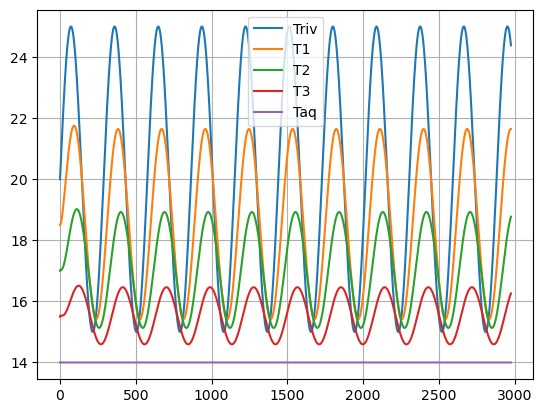

In [8]:
# les sorties des différents capteurs après passage dans le modèle direct
nt = 3000
plt.plot(emu_observ_test_user1._T_riv[:nt], label="Triv")
n_sens = len(emu_observ_test_user1._T_Shaft[0])
for i in range(n_sens-1):
    plt.plot(emu_observ_test_user1._T_Shaft[:nt,i], label="T{}".format(i+1))
plt.plot(emu_observ_test_user1._T_Shaft[:nt,n_sens-1], label="Taq")
plt.legend()
plt.grid()

# la valeur moyenne diminue (ce qui ne devrait pas arriver)

Text(0.5, 0, 't')

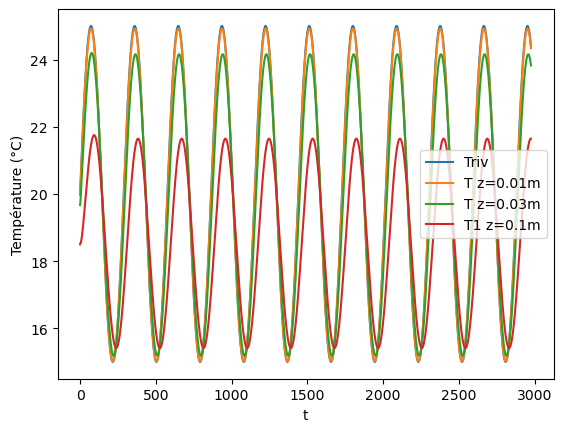

In [9]:
plt.plot(emu_observ_test_user1._T_riv, label="Triv")
plt.plot(col._temps[0,:], label="T z=0.01m")
plt.plot(col._temps[5,:], label="T z=0.03m")
plt.plot(emu_observ_test_user1._T_Shaft[:,0], label="T1 z=0.1m")
plt.legend()
plt.ylabel("Température (°C)")
plt.xlabel("t")

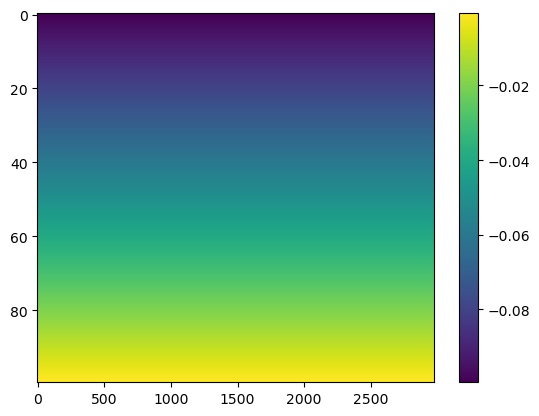

In [10]:
im = plt.imshow(col._H_res, aspect="auto")
plt.colorbar(im)

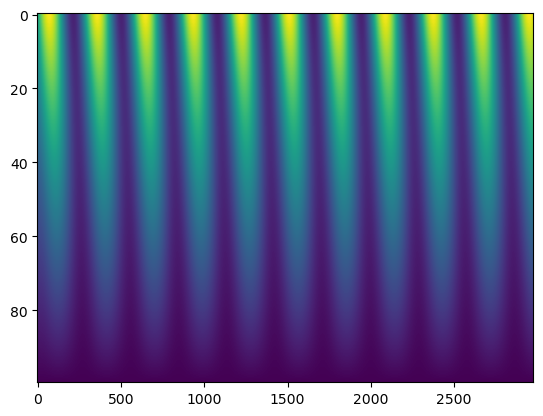

In [11]:
plt.imshow(col._temps[:,:3000], aspect='auto')
# on voit bien le déphasage mais a encore cette modulation

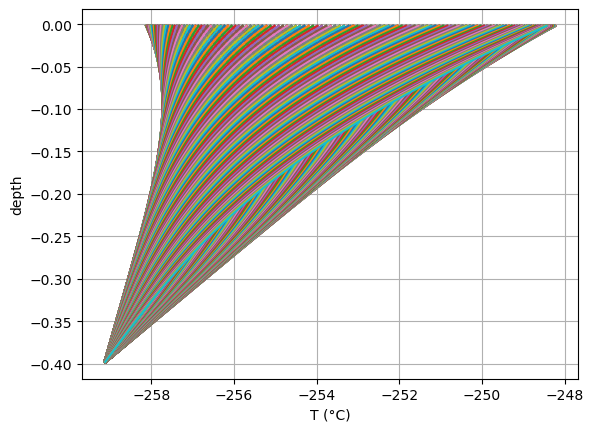

In [12]:
nt = len(col._temps[0,:])
for i in range(1500):
    plt.plot(col._temps[:,i]-ZERO_CELSIUS, -col._z_solve)
plt.ylabel("depth")
plt.xlabel("T (°C)")
plt.grid()
#plt.xlim(282,286)

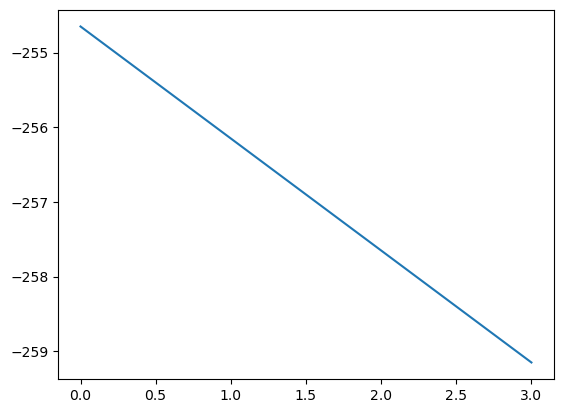

In [13]:
plt.plot(emu_observ_test_user1._T_Shaft[0]-ZERO_CELSIUS)

In [14]:
emu_observ_test_user1._T_Shaft_measures

[(datetime.datetime(2011, 8, 1, 0, 0), array([18.5, 17. , 15.5, 14. ])),
 (datetime.datetime(2011, 8, 1, 0, 15),
  array([18.53017998, 17.02997017, 15.52997971, 14.        ])),
 (datetime.datetime(2011, 8, 1, 0, 30),
  array([18.53146172, 17.02994728, 15.52994537, 14.        ])),
 (datetime.datetime(2011, 8, 1, 0, 45),
  array([18.53531647, 17.02994347, 15.52991962, 14.        ])),
 (datetime.datetime(2011, 8, 1, 1, 0),
  array([18.54293442, 17.02999306, 15.52989292, 14.        ])),
 (datetime.datetime(2011, 8, 1, 1, 15),
  array([18.5547123 , 17.0301857 , 15.52986336, 14.        ])),
 (datetime.datetime(2011, 8, 1, 1, 30),
  array([18.57052231, 17.03063393, 15.52984905, 14.        ])),
 (datetime.datetime(2011, 8, 1, 1, 45),
  array([18.59005547, 17.0314827 , 15.52984238, 14.        ])),
 (datetime.datetime(2011, 8, 1, 2, 0),
  array([18.61301994, 17.03286743, 15.52984905, 14.        ])),
 (datetime.datetime(2011, 8, 1, 2, 15),
  array([18.63907051, 17.03491211, 15.52989006, 14.      

Text(0.5, 0, 'H (m)')

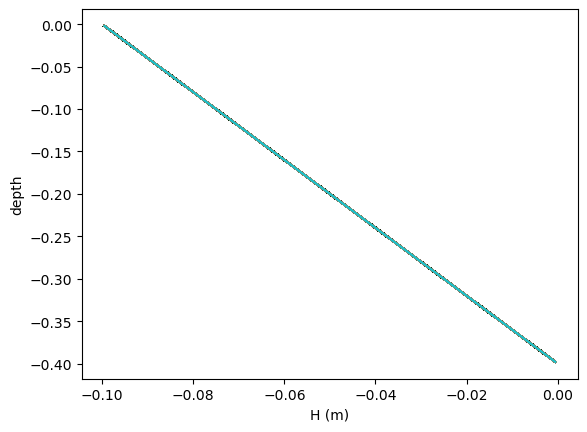

In [15]:
nt = len(col._H_res[0,:])
for i in range(1000):
    plt.plot(col._H_res[:,i], -col._z_solve)
plt.ylabel("depth")
plt.xlabel("H (m)")

Plotting Température in column. time series have nrecords =  2976


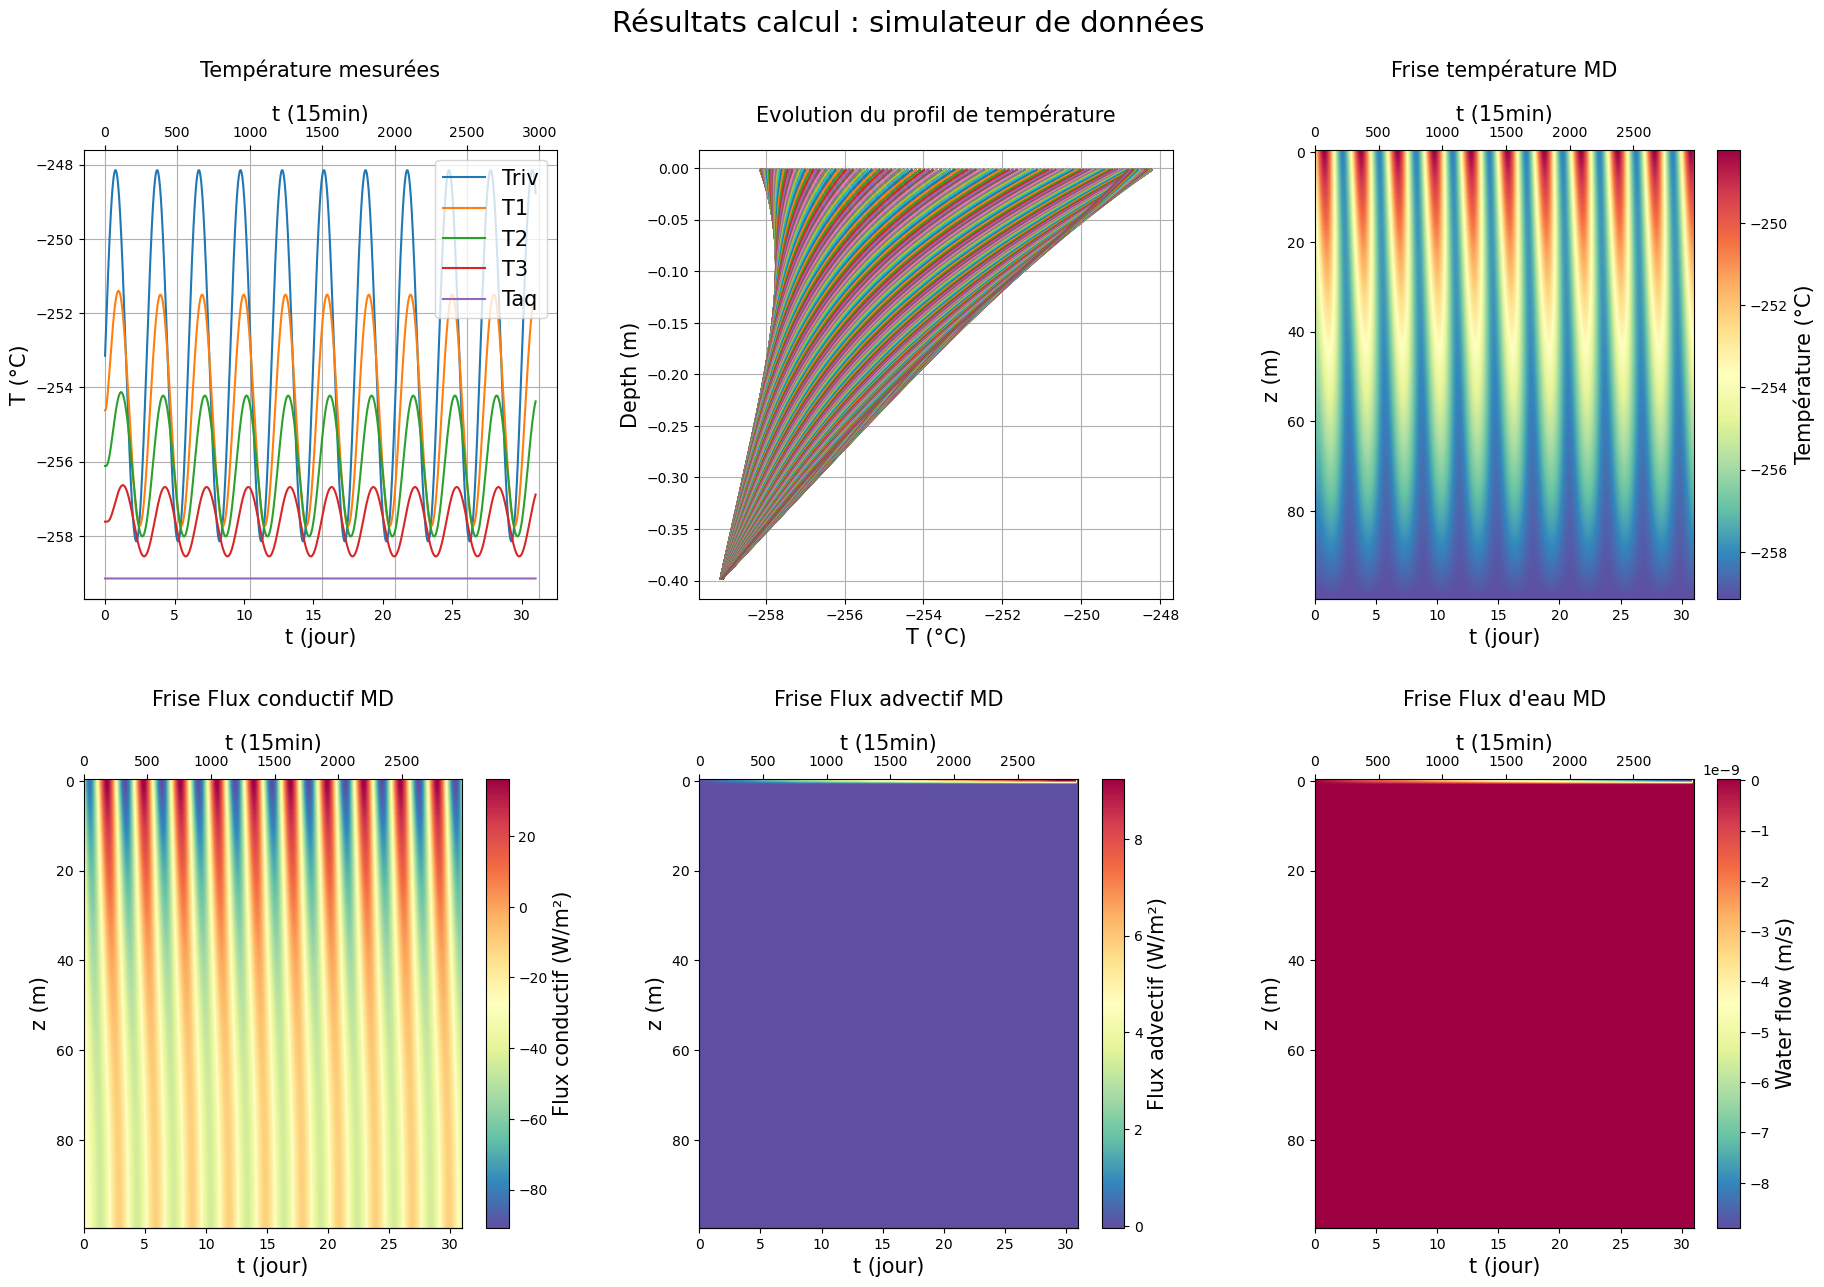

In [16]:
col.plot_CALC_results()

## 2. Cas avec perturbation des observations

In [17]:
#nb_cells = 100
#emu_observ_test_user2._measures_column_one_layer(col2, layers_list2, nb_cells)

emu_observ_test_user1._generate_perturb_T_riv_dH_series()
emu_observ_test_user1._generate_perturb_Shaft_Temp_series()

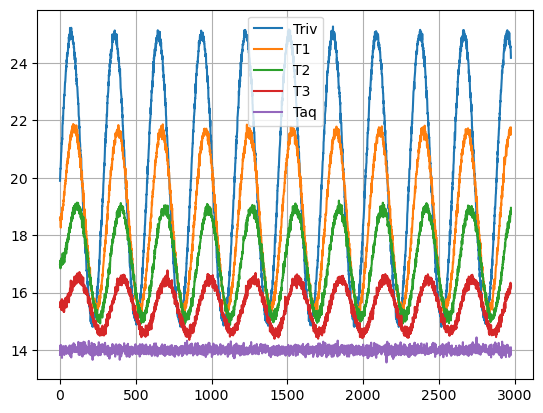

In [18]:
# les sorties des différents capteurs après passage dans le modèle direct
nt = 3000
plt.plot(emu_observ_test_user1._T_riv_perturb[:nt], label="Triv")
n_sens = len(emu_observ_test_user1._T_Shaft_perturb[0])
for i in range(n_sens-1):
    plt.plot(emu_observ_test_user1._T_Shaft_perturb[:nt,i], label="T{}".format(i+1))
plt.plot(emu_observ_test_user1._T_Shaft_perturb[:nt,n_sens-1], label="Taq")
plt.legend()
plt.grid()

# Test valeur par défaut de la classe émulation

In [19]:
time_series_dict_user3 = {
    "offset" : 0,
    "depth_sensors":depth_sensors,
}

In [20]:
emu_observ_test_user3 = Time_series.from_dict(time_series_dict_user3)

emu_observ_test_user3._generate_Shaft_Temp_series()
emu_observ_test_user3._T_Shaft_measures

[(datetime.datetime(1970, 1, 1, 1, 0), array([nan, nan, nan, 12.])),
 (datetime.datetime(1970, 1, 1, 1, 0, 15),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.20327249e+01])),
 (datetime.datetime(1970, 1, 1, 1, 0, 30),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.20654498e+01])),
 (datetime.datetime(1970, 1, 1, 1, 0, 45),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.20981746e+01])),
 (datetime.datetime(1970, 1, 1, 1, 1),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.21308993e+01])),
 (datetime.datetime(1970, 1, 1, 1, 1, 15),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.21636238e+01])),
 (datetime.datetime(1970, 1, 1, 1, 1, 30),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.21963481e+01])),
 (datetime.datetime(1970, 1, 1, 1, 1, 45),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.22290722e+01])),
 (datetime.datetime(1970, 1, 1, 1, 2),
  array([9.59595000e+05, 9.59595000e+05, 9.59595000e+05, 1.2261

# Test du cas multilayer 

In [21]:
t_debut = (2011, 8, 1)
t_fin = (2011, 8, 31, 23, 59, 59)
dt = 15*60 # pas de temps en (s)

T_riv_amp = 2
T_riv_offset = 20
P_T_riv = 72*4*dt

T_aq_amp = 0
T_aq_offset = 14
P_T_aq = 9999 # à mettre dans le init

dH_amp = 0
dH_offset = 1
P_dh = -9999 #14*24*4*dt

depth_sensors = [.1, .15, .25, .3, .4] # on a mis 5 capteurs dans le shaft au lieu de 4 pour montrer que le code s'adapte

In [22]:
time_series_dict_user4 = {
    "offset" : 0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_amp, P_T_riv, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": 0.05,
    "sigma_meas_T": 0.1, #float
}

In [23]:
emu_observ_test_user4 = Time_series.from_dict(time_series_dict_user4)

emu_observ_test_user4._generate_dates_series()
emu_observ_test_user4._generate_Temp_aq_series()
emu_observ_test_user4._generate_T_riv_dH_series()
emu_observ_test_user4._generate_Temp_riv_series()
emu_observ_test_user4._generate_Shaft_Temp_series()

In [24]:
# l'utilisateur génère un dictionnaire avec les données importantes de la colonne
name = ["gravier","Couche en sable"]
zLow = [.2,.4]
moinslog10K = [4,10]
n = [.4,.1]
lambda_s = [2,2] 
rhos_cs = [4e6,4e6]

# on utilise les mesures générées précédemment
col_dict4 = {
	"river_bed": 1., 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user4._T_riv_dH_measures,
    "T_measures": emu_observ_test_user4._T_Shaft_measures,
    "sigma_meas_P": emu_observ_test_user4._sigma_P, #float
    "sigma_meas_T": emu_observ_test_user4._sigma_T, #float
}

col4 = Column.from_dict(col_dict4)

# modèle une couche
layers_list4= layersListCreator([(name[i], zLow[i], moinslog10K[i], n[i], lambda_s[i], rhos_cs[i]) for i in range(len(name))])

In [25]:
nb_cells = 100
emu_observ_test_user4._measures_column_one_layer(col4, layers_list4, nb_cells)

emu_observ_test_user4._generate_perturb_T_riv_dH_series()
emu_observ_test_user4._generate_perturb_Shaft_Temp_series()

--- Compute Solve Transi ---
gravier : ends at 0.2 m. Parametres(moinslog10K=4, n=0.4, lambda_s=2, rhos_cs=4000000.0)
Couche en sable : ends at 0.4 m. Parametres(moinslog10K=10, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Hinter [-1.       -0.999999  0.      ]
conditions aux limites
H_riv [-1.       -1.180018 -1.360036 ...  1.        1.        1.      ]
H_aq [0. 0. 0. ... 0. 0. 0.]
échantillons du profondeur: ...  0.198 0.202  ...
le profondeur d'interface:  0.2
type cara asymetric
Done.


In [26]:
emu_observ_test_user4._T_Shaft_perturb

array([[18.74335168, 17.91140368, 16.25628153, 15.41422796, 13.95911625],
       [18.64978651, 17.64331732, 16.10963116, 15.50662652, 13.97156833],
       [18.50338059, 17.5812392 , 16.31057129, 15.53770149, 14.01449567],
       ...,
       [19.66218496, 18.55754769, 16.57898025, 15.85884046, 13.96524405],
       [19.65116083, 18.70252389, 16.69145663, 15.69870155, 14.03819807],
       [19.75390102, 18.71115566, 16.74471271, 15.7079217 , 13.93345762]])

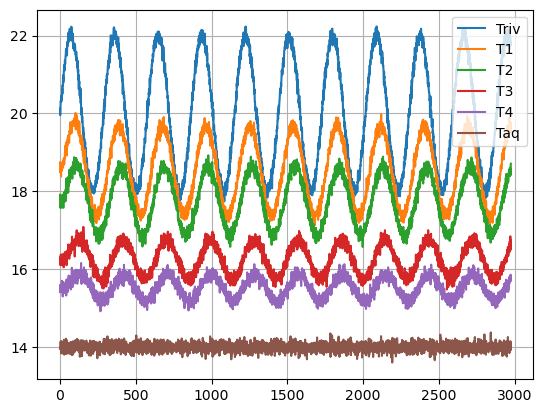

In [27]:
# les sorties des différents capteurs après passage dans le modèle direct
nt = 3000
plt.plot(emu_observ_test_user4._T_riv_perturb[:nt], label="Triv")
n_sens = len(emu_observ_test_user4._T_Shaft_perturb[0])
for i in range(n_sens-1):
    plt.plot(emu_observ_test_user4._T_Shaft_perturb[:nt,i], label="T{}".format(i+1))
plt.plot(emu_observ_test_user4._T_Shaft_perturb[:nt,n_sens-1], label="Taq")
plt.legend()
plt.grid()

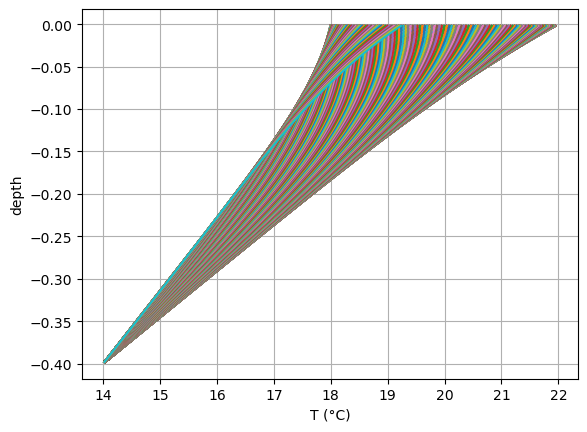

In [28]:
nt = len(col4._temps[0,:])
for i in range(1000,2000):
    plt.plot(col4._temps[:,i], -col._z_solve)
plt.ylabel("depth")
plt.xlabel("T (°C)")
plt.grid()
#plt.xlim(282,286)

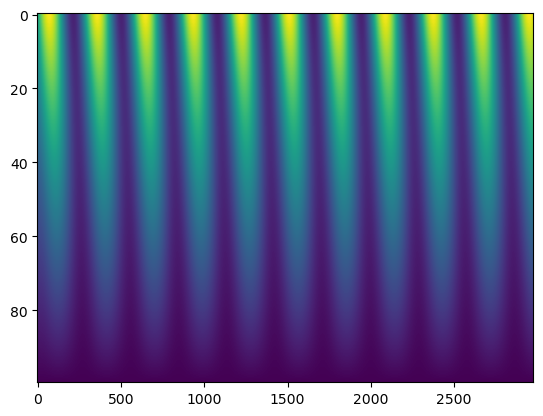

In [29]:
plt.imshow(col._temps[:,:], aspect='auto')